In [214]:
# the clustering using KMeans: sns plots

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def Kmeans_clustering(data, drop_columns=[], n_clusters=None, figsize=(10, 6), dot_size=100, alpha=0.7):

    # 1. Data preparation
    X = data.drop(drop_columns, axis=1)

    # 2. Find optimal number of clusters using the elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10) # Explicitly set n_init parameter
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Draw elbow plot
    plt.figure(figsize=figsize)
    sns.lineplot(x=range(1, 11), y=wcss, marker='o', markersize=8)
    plt.title('The Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Decide the optimal number of clusters
    if n_clusters is None:
        n_clusters = int(input("Enter the optimal number of clusters based on the elbow plot: "))

    # 3. Training the K-means models on the data
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0, n_init=10) # Explicitly set n_init parameter
    y_kmeans = kmeans.fit_predict(X)

    # 4. Draw scatter plot showing the generated clusters
    plt.figure(figsize=figsize)
    for i in range(n_clusters):
        sns.scatterplot(x=X.iloc[y_kmeans == i, 0], y=X.iloc[y_kmeans == i, 1], s=dot_size, alpha=alpha, label=f'Cluster {i+1}')
        
    sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], s=dot_size, color='black', marker='X', label='Centroids', alpha=1.0)
    plt.title('Clusters')
    plt.xlabel('X feature')
    plt.ylabel('Y feature')
    plt.legend()
    plt.show()

    return y_kmeans


In [241]:
# improved version

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings


def kmeans_clustering_geological_data(data, drop_columns, n_clusters=None, random_state=42, figsize=(15, 12), dot_size=20,
                                      hue='Cluster', col=None, style=None, size=None, palette='coolwarm',
                                      alpha=0.7, x_feature='Longitude', y_feature='Latitude', sizes=(2, 200)):
    """
    Perform k-means clustering on geological data and visualize the clusters using a scatter plot.

    Parameters:
    -----------
    data : pandas DataFrame
        The dataset to be used for clustering.
    drop_columns : list
        The list of column names to be dropped from the dataset before clustering.
    n_clusters : int or None, default=None
        The number of clusters to form. If None, the optimal number of clusters will be determined using the elbow method.
    random_state : int, default=42
        The seed used by the random number generator.
    figsize : tuple, default=(15, 12)
        The size of the figure to be plotted.
    dot_size : int, default=20
        The size of the dots in the scatter plot.
    hue : str, default='Cluster'
        The name of the column to use for coloring the points according to the cluster they belong to.
    col : str or None, default=None
        The name of the column to use for creating subplots. If None, a single plot will be created.
    style : str or None, default=None
        The name of the column to use for differentiating the point markers according to the cluster they belong to.
    size : str or None, default=None
        The name of the column to use for varying the size of the point markers according to the cluster they belong to.
    palette : str or list, default='coolwarm'
        The color palette to use for coloring the points according to the cluster they belong to.
    alpha : float, default=0.7
        The alpha value to use for the point markers in the scatter plot.
    x_feature : str, default='Longitude'
        The name of the column to use for the x-axis of the scatter plot.
    y_feature : str, default='Latitude'
        The name of the column to use for the y-axis of the scatter plot.
    sizes : tuple, default=(2, 200)
        The range of marker sizes to be used in the scatter plot, specified as a tuple of (min_size, max_size).

    Returns:
    --------
    df : pandas DataFrame
        The original dataset with an additional column indicating the cluster label for each data point.

    Raises:
    -------
    ValueError
        If the specified columns to drop are not present in the dataset.
        If the specified column names for hue, col, style, or size are not present in the dataset.
    """

    # Drop specified columns
    if not set(drop_columns).issubset(set(data.columns)):
        raise ValueError("The specified columns to drop are not present in the dataset.")
    X = data.drop(columns=drop_columns)

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Determine the optimal number of clusters using the elbow method
    if n_clusters is None:
        sum_of_squared_distances = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters=i, random_state=random_state)
            kmeans.fit(X_scaled)
            sum_of_squared_distances.append(kmeans.inertia_)

        plt.plot(range(1, 11), sum_of_squared_distances, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Sum of Squared Distances')
        plt.title('Elbow Method For Optimal Number of Clusters')
        plt.show()

        n_clusters = int(input("Enter the optimal number of clusters: "))

    # Perform k-means clustering
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = kmeans.fit_predict(X_scaled)
        data['Cluster'] = cluster_labels

    # Inverse transform the cluster centroids to the original feature space
    centroids_unscaled = scaler.inverse_transform(kmeans.cluster_centers_)

    # Create a scatter plot
    if col is not None:
        if col not in data.columns:
            raise ValueError(f"The specified column name for col ({col}) is not present in the dataset.")
        g = sns.FacetGrid(data, col=col, height=figsize[1]/data[col].nunique(), aspect=figsize[0]/figsize[1])
        g.map_dataframe(sns.scatterplot, x=x_feature, y=y_feature, hue=hue, size=size, size_order=sorted(data[size].unique()), style=style, alpha=alpha, palette=palette, s=dot_size, hue_order=sorted(data[hue].unique()))
        g.map_dataframe(lambda data, color: sns.scatterplot(x=centroids_unscaled[:, X.columns.get_loc(x_feature)], y=centroids_unscaled[:, X.columns.get_loc(y_feature)], s=dot_size, color='black', marker='X', label='Centroids', alpha=1.0, legend=False))
        g.set_titles('{col_name}')
        g.add_legend(title=data[col].name)
    else:
        if hue not in data.columns:
            raise ValueError(f"The specified column name for hue ({hue}) is not present in the dataset.")
        plt.figure(figsize=figsize)
        sns.scatterplot(x=x_feature, y=y_feature, data=data, hue=hue, size=size, size_order=sorted(data[size].unique()), style=style, alpha=alpha, palette=palette, s=dot_size, hue_order=sorted(data[hue].unique()))
        sns.scatterplot(x=centroids_unscaled[:, X.columns.get_loc(x_feature)], y=centroids_unscaled[:, X.columns.get_loc(y_feature)], s=dot_size, color='black', marker='X', label='Centroids', alpha=1.0)
        plt.title('Clusters')
        plt.xlabel(x_feature)
        plt.ylabel(y_feature)
        plt.legend()
    plt.show()

    return data

In [ ]:
# Improved Version_final

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def kmeans_clustering_geological_data(data, drop_columns, n_clusters=None, random_state=42, figsize=(15, 12), dot_size=20,
                                      hue='Cluster', col=None, style=None, size=None, palette='coolwarm', 
                                      alpha=0.7, x_feature='Longitude', y_feature='Latitude', sizes=(2, 200)):
    """
    Perform KMeans clustering on geological data and visualize the results.

    :param data: DataFrame - The input data containing features.
    :param drop_columns: List of str - Columns to drop from the data before performing clustering.
    :param n_clusters: int, optional - The number of clusters for KMeans. If None, the optimal number of clusters will be determined using the Elbow method.
    :param random_state: int, optional - The random state for KMeans.
    :param figsize: tuple, optional - The figure size of the plot.
    :param dot_size: int, optional - The size of the dots in the plot.
    :param hue: str, optional - The hue (color) parameter for seaborn plots.
    :param col: str, optional - The col (column) parameter for seaborn FacetGrid plots.
    :param style: str, optional - The style parameter for seaborn scatterplot.
    :param size: str, optional - The size parameter for seaborn scatterplot.
    :param palette: str, optional - The color palette for seaborn plots.
    :param alpha: float, optional - The alpha parameter for seaborn plots.
    :param x_feature: str, optional - The x-axis feature in the plot.
    :param y_feature: str, optional - The  y-axis feature in the plot.
    :param sizes: tuple, optional - The sizes parameter for seaborn scatterplot.

    :return: DataFrame - The input data with an additional 'Cluster' column representing the cluster labels.
    """
    try:
        # Create a copy of the input data and drop the specified columns
        original_data = data.copy()
        X = data.drop(columns=drop_columns)
        
        # Standardize the remaining features using StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # If the number of clusters is not provided, determine the optimal number using the Elbow method
        if n_clusters is None:
            sum_of_squared_distances = []
            for i in range(1, 11):
                kmeans = KMeans(n_clusters=i, random_state=random_state)
                kmeans.fit(X_scaled)
                sum_of_squared_distances.append(kmeans.inertia_)

            plt.plot(range(1, 11), sum_of_squared_distances, marker='o')
            plt.xlabel('Number of clusters')
            plt.ylabel('Sum of Squared Distances')
            plt.title('Elbow Method For Optimal Number of Clusters')
            plt.show()

            n_clusters = int(input("Enter the optimal number of clusters: "))
            
            
        # Perform KMeans clustering with the determined number of clusters    
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # Add the cluster labels to the original data
        original_data['Cluster'] = cluster_labels
        
        # Calculate the unscaled centroids
        centroids_unscaled = scaler.inverse_transform(kmeans.cluster_centers_)

        # Visualize the clustered data and centroids using seaborn
        if col is not None:
            g = sns.FacetGrid(original_data, col=col, height=figsize[1]/X[col].nunique(), aspect=figsize[0]/figsize[1])
            g.map_dataframe(sns.scatterplot, x=x_feature, y=y_feature, hue=hue, size=size, style=style, alpha=alpha, palette=palette, s=dot_size)
            g.map_dataframe(lambda data, color: sns.scatterplot(x=centroids_unscaled[:, X.columns.get_loc(x_feature)], y=centroids_unscaled[:, X.columns.get_loc(y_feature)], s=dot_size, color='black', marker='X', label='Centroids', alpha=1.0, legend=False))
            g.set_titles('{col_name}')
            g.add_legend(title=original_data[col].name)
        else:
            plt.figure(figsize=figsize)
            sns.scatterplot(x=x_feature, y=y_feature, data=original_data, hue=hue, size=size, style=style, alpha=alpha, palette=palette, s=dot_size)
            sns.scatterplot(x=centroids_unscaled[:, X.columns.get_loc(x_feature)], y=centroids_unscaled[:, X.columns.get_loc(y_feature)], s=dot_size, color='black', marker='X', label='Centroids', alpha=1.0)
            plt.title('Clusters')
            plt.xlabel(x_feature)
            plt.ylabel(y_feature)
            plt.legend()
        plt.show()
        
        df = original_data
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
if __name__ == '__main__':
    data = pd.read_csv('data.csv')
    kmeans_clustering(data, drop_columns=['drop_column_1', 'drop_column_2'])

In [76]:
df = pd.read_csv('/home/young78703/Data_Science_Project/data/melb_data.csv')

In [77]:
df.rename(columns={'Longtitude':'Longitude', 'Lattitude':'Latitude'},inplace=True)

In [78]:
import pandas as pd
import numpy as np

def impute_nulls(df):
    """
    Impute null values in a Pandas DataFrame based on the data type of each column.
    - For float columns, impute with the mean.
    - For integer columns, impute with the median.
    - For object columns, impute with the mode.
    - For datetime columns, impute with the most recent or most frequent date.
    - For timedelta columns, impute with the mode.
    - For bool columns, impute with the mode.
    - For category columns, impute with the mode.
    - For complex columns, impute with the mean.
    """
    # Get data types of all columns
    dtypes = df.dtypes

    # Iterate over all columns
    for col in df.columns:
        # Check if column contains null values
        if df[col].isnull().sum() > 0:
            # Get data type of column
            dtype = dtypes[col]
            # Impute null values based on data type
            if dtype == 'float64' or dtype == 'float32' or dtype == 'float16':
                df[col].fillna(df[col].mean(), inplace=True)
            elif dtype == 'int64' or dtype == 'int32' or dtype == 'int16' or dtype == 'int8':
                df[col].fillna(df[col].median(), inplace=True)
            elif dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            elif dtype == 'datetime64':
                df[col].fillna(method='bfill', inplace=True)
            elif dtype == 'timedelta64':
                df[col].fillna(df[col].mode()[0], inplace=True)
            elif dtype == 'bool':
                df[col].fillna(df[col].mode()[0], inplace=True)
            elif dtype.name == 'category':
                df[col].fillna(df[col].mode()[0], inplace=True)
            elif dtype == 'complex64' or dtype == 'complex128':
                df[col].fillna(df[col].mean(), inplace=True)
    return df

In [79]:
impute_nulls(df)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,151.96765,1964.684217,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.00000,1900.000000,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.00000,1900.000000,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,151.96765,1964.684217,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.00000,2014.000000,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,151.96765,1981.000000,Moreland,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.00000,1995.000000,Moreland,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,151.96765,1997.000000,Moreland,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.00000,1920.000000,Moreland,-37.85908,144.89299,Western Metropolitan,6380.0


In [80]:
from scipy import stats

def drop_outliers_by_zscores(data, column, lower_zscore, upper_zscore, inplace=False):
    """
    Drops rows from a Pandas DataFrame based on z-scores of a given column.

    Parameters:
    data (pandas.DataFrame): The input data.
    column (str): The name of the column to use for computing z-scores.
    lower_zscore (float): The lower z-score boundary.
    upper_zscore (float): The upper z-score boundary.
    inplace (bool): If True, updates the DataFrame directly. If False, returns a new DataFrame with outliers dropped.

    Returns:
    pandas.DataFrame or None: The modified DataFrame with outliers dropped, if inplace is False;
                              None, if inplace is True.
    """
    # Check input arguments
    if column not in data.columns:
        raise ValueError("Column '%s' not found in data." % column)
    if not np.isfinite(lower_zscore):
        raise ValueError("Lower z-score boundary must be finite.")
    if not np.isfinite(upper_zscore):
        raise ValueError("Upper z-score boundary must be finite.")

    # Compute z-scores
    z_scores = pd.Series(stats.zscore(data[column]), index=data.index)

    # Drop outliers outside boundaries
    mask = (z_scores >= upper_zscore) | (z_scores <= lower_zscore)
    
    if inplace:
        data.drop(data[mask].index, inplace=True)
        return None
    else:
        return data.loc[~mask]


In [81]:
drop_outliers_by_zscores(df, 'Price', -3.5, 3.5, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13439 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13439 non-null  object 
 1   Address        13439 non-null  object 
 2   Rooms          13439 non-null  int64  
 3   Type           13439 non-null  object 
 4   Price          13439 non-null  float64
 5   Method         13439 non-null  object 
 6   SellerG        13439 non-null  object 
 7   Date           13439 non-null  object 
 8   Distance       13439 non-null  float64
 9   Postcode       13439 non-null  float64
 10  Bedroom2       13439 non-null  float64
 11  Bathroom       13439 non-null  float64
 12  Car            13439 non-null  float64
 13  Landsize       13439 non-null  float64
 14  BuildingArea   13439 non-null  float64
 15  YearBuilt      13439 non-null  float64
 16  CouncilArea    13439 non-null  object 
 17  Lattitude      13439 non-null  float64
 18  Longit

In [82]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from typing import Optional

def encode_categorical_column(data: pd.DataFrame, column: str, mapping: Optional[dict] = None) -> pd.DataFrame:
    """
    Encode a categorical column in the input dataframe using LabelEncoder or mapping.

    :param data: input dataframe
    :param column: column name to be encoded
    :param mapping: optional dictionary defining the mapping for ordinal variables; defaults to None
    :return: dataframe with the specified column encoded
    """
    data = data.copy()

    if mapping is not None:
        # Use mapping for ordinal categorical variables
        data[column] = data[column].map(mapping)
    else:
        # Use LabelEncoder for nominal categorical variables
        encoder = LabelEncoder()
        encoded = encoder.fit_transform(data[column])
        data[column] = encoded

    return data

In [83]:
encode_categorical_column(df, 'Method')

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,1,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,151.96765,1964.684217,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,1,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.00000,1900.000000,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,3,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.00000,1900.000000,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,0,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,151.96765,1964.684217,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,4,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.00000,2014.000000,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,1,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,151.96765,1981.000000,Moreland,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,3,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.00000,1995.000000,Moreland,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,1,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,151.96765,1997.000000,Moreland,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,0,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.00000,1920.000000,Moreland,-37.85908,144.89299,Western Metropolitan,6380.0


In [84]:
encode_categorical_column(df, 'Type')

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,0,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,151.96765,1964.684217,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,0,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.00000,1900.000000,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,0,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.00000,1900.000000,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,0,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,151.96765,1964.684217,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,0,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.00000,2014.000000,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,0,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,151.96765,1981.000000,Moreland,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,0,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.00000,1995.000000,Moreland,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,0,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,151.96765,1997.000000,Moreland,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,0,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.00000,1920.000000,Moreland,-37.85908,144.89299,Western Metropolitan,6380.0


/home/young78703/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/young78703/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/young78703/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/young78703/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/hom

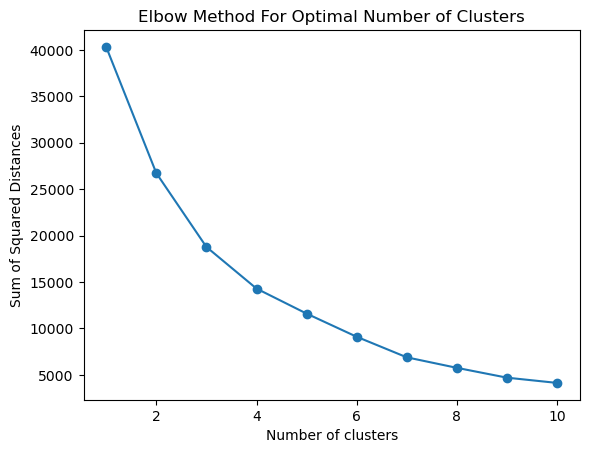

Enter the optimal number of clusters: 10


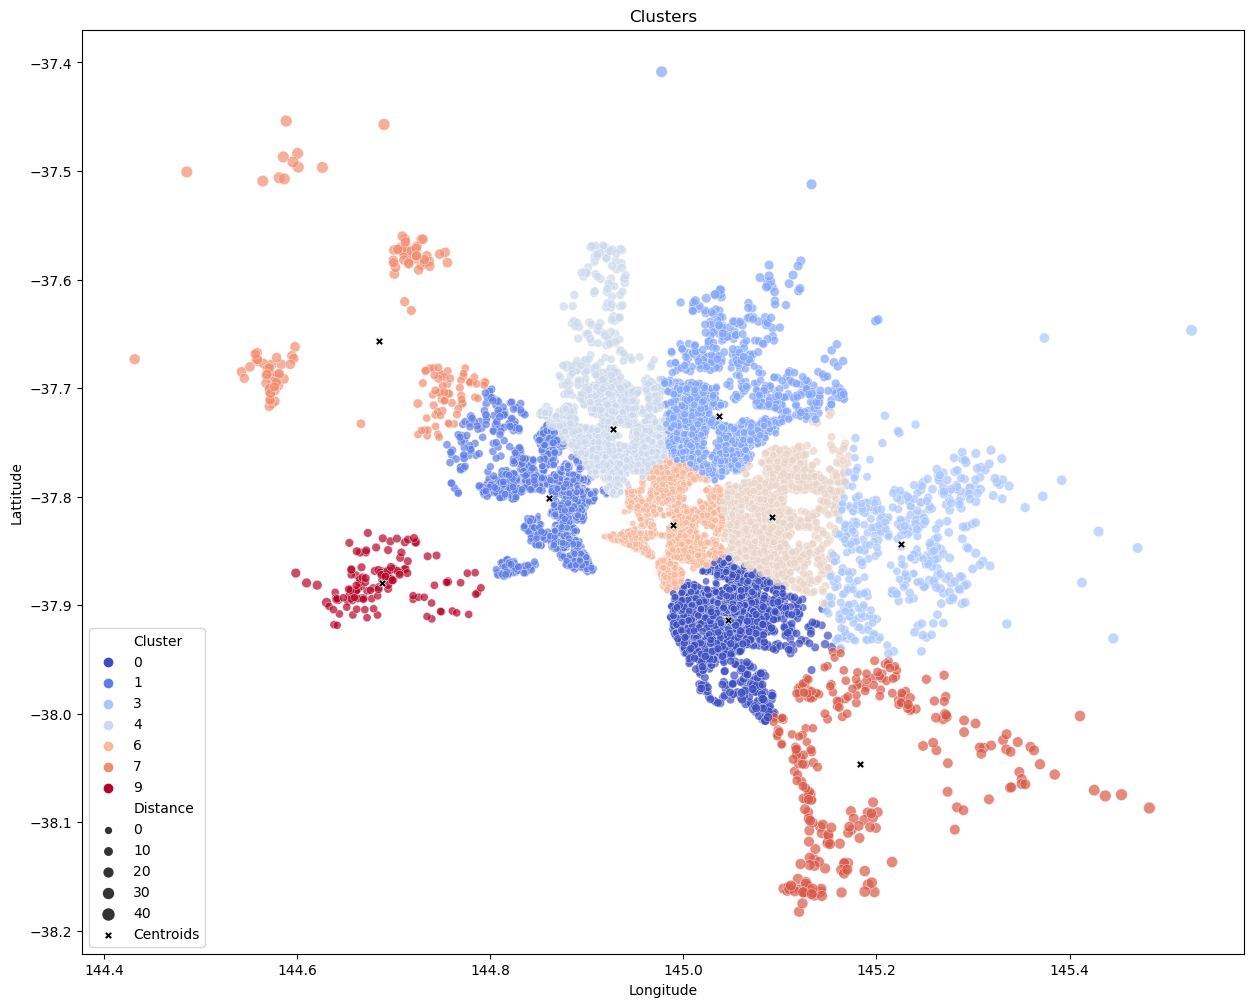

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longitude,Regionname,Propertycount,Cluster
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,202.0,151.96765,1964.684217,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,6
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,0.0,156.0,79.00000,1900.000000,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,6
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,0.0,134.0,150.00000,1900.000000,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,6
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,1.0,94.0,151.96765,1964.684217,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,6
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,2.0,120.0,142.00000,2014.000000,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,652.0,151.96765,1981.000000,Moreland,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,3
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,333.0,133.00000,1995.000000,Moreland,-37.85927,144.87904,Western Metropolitan,6380.0,1
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,4.0,436.0,151.96765,1997.000000,Moreland,-37.85274,144.88738,Western Metropolitan,6380.0,1
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,5.0,866.0,157.00000,1920.000000,Moreland,-37.85908,144.89299,Western Metropolitan,6380.0,1


In [242]:
drop_columns=['Suburb', 'Address','Type','Rooms', 'Method', 'SellerG', 'Date', 'Bedroom2', 'Distance', 'Postcode', 'Price', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Regionname', 'Propertycount']
kmeans_clustering_geological_data(df, drop_columns, n_clusters=None, figsize=(15, 12), dot_size=30, hue='Cluster', palette='coolwarm', size='Distance', sizes=(1,300), alpha=0.7, x_feature='Longitude', y_feature='Lattitude')

In [15]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [252]:
contingency_table = pd.crosstab(index=df['Cluster'], columns=[df['Type'], df['Method']])

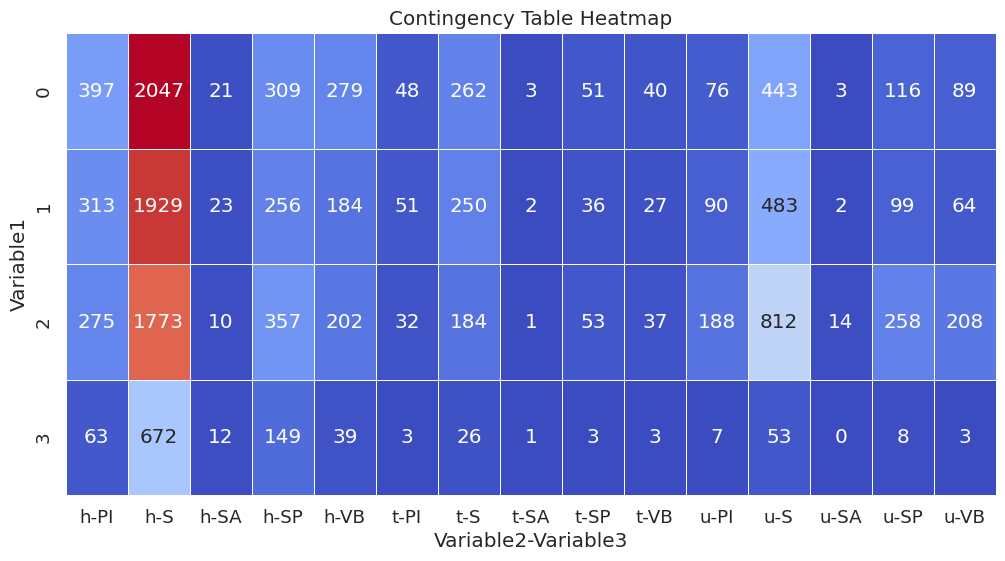

In [256]:
# Create a heatmap of the contingency table
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', linewidths=0.5, fmt='g', cbar=False)
plt.title('Contingency Table Heatmap')
plt.xlabel('Variable2-Variable3')
plt.ylabel('Variable1')

# Display the plot
plt.show()